In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import glob
import os.path as osp
import cv2

In [2]:
class MNISTDataset(Dataset):
    def __init__(self, root, transform = None, preload = False):
        self.images = None
        self.labels = None
        self.fileNames = []
        self.root = root
        self.transform = transform
        
        for i in range(10):
            for filename in glob.glob(osp.join(root, str(i), "*.png")):
                self.fileNames.append((filename, i))

        self.len = len(self.fileNames)
        
        if preload: self.__preload()
        
    def __preload(self):
        self.labels = []
        self.images = []
        for fn, label in self.fileNames:
            self.images.append(cv2.cvtColor(cv2.imread(fn), cv2.COLOR_BGR2GRAY))
            self.labels.append(label)

    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        label = None
        image = None
        if self.images is not None:
            image = self.images[index]
            label = self.labels[index]
        else:
            fn, label = self.fileNames[index]
            image = cv2.imread(fn)
        
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [4]:
trainset = MNISTDataset("./mnist_png/training", 
                        transform = transforms.ToTensor(), 
                        preload = True)

testset = MNISTDataset("./mnist_png/testing", 
                        transform = transforms.ToTensor(), 
                        preload = True)

trainsetLoader = DataLoader(trainset, batch_size = 64, shuffle = True, num_workers = 1)
testsetLoader = DataLoader(testset, batch_size = 1000, shuffle = False, num_workers = 1)
print(f"train set length = {len(trainset)}")
print(f"test set length = {len(testset)}")

train set length = 60000
test set length = 10000


In [5]:
useCuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device("cuda" if useCuda else "cpu")

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size = 5)
        self.maxPool1 = nn.MaxPool2d(kernel_size = 2)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(10, 20, kernel_size = 5)
        self.dropOut2 = nn.Dropout2d()
        self.maxPool2 = nn.MaxPool2d(kernel_size = 2)
        self.relu2 = nn.ReLU()
        
        self.fc1 = nn.Linear(320, 2)
        self.fc2 = nn.Linear(2, 10)
        
    def forward(self, x):
        x = self.relu1(self.maxPool1(self.conv1(x)))
        x = self.relu2(self.maxPool2(self.dropOut2(self.conv2(x))))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        return F.log_softmax(self.fc2(x), dim = 1)

    def getFc1Features(self, x):
        x = self.relu1(self.maxPool1(self.conv1(x)))
        x = self.relu2(self.maxPool2(self.dropOut2(self.conv2(x))))
        x = x.view(-1, 320)
        return self.fc1(x)

In [15]:
from time import time

def train(model, trainDataLoader, testDataLoader, epoch, logInterval = 100):
    model.train()
    iteration = 0
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    for e in range(epoch):
        start = time()
        for batchIndex, (data, label) in enumerate(trainDataLoader):
            data, label = data.to(device), label.to(device)
            output = model(data)
            loss = F.nll_loss(output, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if iteration % logInterval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    e, batchIndex * len(data), len(trainDataLoader.dataset),
                    100. * batchIndex / len(trainDataLoader), loss.item()))
            iteration += 1
        end = time()
        print('{:.2f}s'.format(end-start))

def test(model, testDataLoader):
    model.eval()
    testLoss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testDataLoader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            testLoss = F.nll_loss(output, target, size_average=False).item()
            prediction = output.max(1, keep_dim = True)[1]
            correct += prediction.eq(target.view_as(pred)).sum().item()

    testLoss /= len(testDataLoader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        testLoss, correct, len(testDataLoader.dataset),
        100. * correct / len(testDataLoader.dataset)))

In [16]:
model = Net().to(device)
train(model, trainsetLoader, testsetLoader, 5)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.404763
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.407550
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.272825
Train Epoch: 0 [19200/60000 (32%)]	Loss: 2.302207
Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.316220
Train Epoch: 0 [32000/60000 (53%)]	Loss: 2.179775
Train Epoch: 0 [38400/60000 (64%)]	Loss: 2.027671
Train Epoch: 0 [44800/60000 (75%)]	Loss: 2.016896
Train Epoch: 0 [51200/60000 (85%)]	Loss: 1.961056
Train Epoch: 0 [57600/60000 (96%)]	Loss: 1.913489
23.43s
Train Epoch: 1 [3968/60000 (7%)]	Loss: 1.658567
Train Epoch: 1 [10368/60000 (17%)]	Loss: 1.790029
Train Epoch: 1 [16768/60000 (28%)]	Loss: 1.787509
Train Epoch: 1 [23168/60000 (39%)]	Loss: 1.741358
Train Epoch: 1 [29568/60000 (49%)]	Loss: 1.558836
Train Epoch: 1 [35968/60000 (60%)]	Loss: 1.584484
Train Epoch: 1 [42368/60000 (71%)]	Loss: 1.559514
Train Epoch: 1 [48768/60000 (81%)]	Loss: 1.465589
Train Epoch: 1 [55168/60000 (92%)]	Loss: 1.589524
23.69s
Train Epoch: 2 [1536/60000 (3%)]	Loss: 1.483

In [31]:
import matplotlib.pyplot as plt

model.eval()
features = []
labels = []
for image, label in trainsetLoader:
    fc1Feature = model.getFc1Features(image)
    features.append(fc1Feature.detach().numpy())
    labels.append(label)
    
features = np.concatenate(features)
labels = np.concatenate(labels)

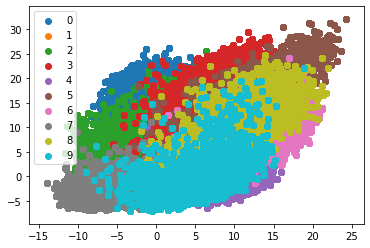

In [46]:
labelSet = set(labels)
featureLabel = {}

for label in labelSet:
    featureLabel[label] = []
for label in labelSet:
    for i in range(len(features)):
        featureLabel[labels[i]].append(features[i])
        
for label in labelSet:
    featureLabel[label] = np.array(featureLabel[label])

for label in labelSet:
    plt.scatter(featureLabel[label][:, 0], featureLabel[label][:, 1], label = str(label))
plt.legend()